# Introduction

I am using the data from Tensorflow Datasets. This dataset was also posted on the [QuickDraw](https://www.kaggle.com/google/tinyquickdraw) Google Kaggle Competition. 

This dataset was created by Google's [Quick Draw](https://quickdraw.withgoogle.com/data) - which has over 50 Million sketches from around the world.

# Problem:
Predict the 

# Summary 
A lot of the work is front heavy. Meaning there is a lot of cleaning and preparing the data before we even start to look at the model. This is very realistic during an actual data science project. A lot this code was inspired by various methodologies posted on Kaggle and StackOverflow. 

However, in contrast, the model is very basic, assuming you understand what an Long Short-Term Memory (LSTM) cell is.

# Load Data

Loading data from tensorflow directly. 

In [1]:
from pathlib import Path 
import tensorflow as tf
assert tf.__version__ > "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 9s 0us/step


Split into training and testing files.

In [2]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [3]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

Look at the classes

In [4]:
# load all classes
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [5]:
# check that all classes are equal
assert train_classes == test_classes

# if classes are the same then clean train classes list
class_names = [name.strip().lower() for name in train_classes]

In [6]:
import pprint
pprint.pprint(class_names)
for class_name in sorted(class_names): # 345 class names!
    print(class_name)

['garden hose',
 'lighter',
 'penguin',
 'tractor',
 'sheep',
 'skateboard',
 'mountain',
 'mouse',
 'chandelier',
 'guitar',
 'roller coaster',
 'owl',
 'toilet',
 'map',
 'snail',
 'yoga',
 'spoon',
 'camera',
 'telephone',
 'bench',
 'pig',
 'lion',
 'skull',
 'hand',
 'raccoon',
 'beard',
 'church',
 'animal migration',
 'whale',
 'sun',
 'washing machine',
 'airplane',
 'megaphone',
 'sleeping bag',
 'jail',
 'fire hydrant',
 'car',
 'barn',
 'swing set',
 'rake',
 'paintbrush',
 'van',
 'dragon',
 'sailboat',
 'compass',
 'duck',
 'hat',
 'kangaroo',
 'donut',
 'crocodile',
 'coffee cup',
 'cooler',
 'waterslide',
 'feather',
 'firetruck',
 'stereo',
 'leg',
 'tree',
 'pillow',
 'purse',
 'hourglass',
 'ear',
 'broccoli',
 'goatee',
 'moon',
 'bridge',
 'peas',
 'squiggle',
 'foot',
 'camouflage',
 'string bean',
 'pants',
 'lipstick',
 'jacket',
 'hockey puck',
 'truck',
 'table',
 'hammer',
 'the great wall of china',
 'paint can',
 'fireplace',
 'leaf',
 'apple',
 'beach',
 'w

As you can see there are many classes within the dataset. There are many things we can sketch!

As shown on the original SketchRNN notebook: https://github.com/magenta/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb 

In [7]:
def parse(data_batch):
  """
  This function takes in the sketch data batch and returns sketches, shape and
  label.

  Parameters
  ----------
  data_batch:	A vector (1-D Tensor) of strings, a batch of binary serialized
              Example protos.
  """
  #  A dict mapping feature keys to FixedLenFeature and VarLenFeature values.
  feature_descriptions = {
      "ink": tf.io.VarLenFeature(dtype=tf.float32),
      "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:, 0]
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels

In [8]:
tf.io.VarLenFeature(dtype=tf.float32)

VarLenFeature(dtype=tf.float32)

In [9]:
# create a function to load the data

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  """
  Reads the data from filepaths argument and returns the dataset.
  """
  dataset = tf.data.TFRecordDataset(filepaths,
                                    num_parallel_reads=n_read_threads)
  if cache:
      dataset = dataset.cache()
  if shuffle_buffer_size:
      dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
  return dataset.prefetch(1)

In [10]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [11]:
train_set

<PrefetchDataset shapes: ((None, None, 3), (None,), (None,)), types: (tf.float32, tf.int64, tf.int64)>

# Explore Data

In [12]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]

    # returns column vector of indices where elements within sketch are 1.
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0] 
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

sketches = (32, 188, 3)
lengths = (32,)
labels = (32,)


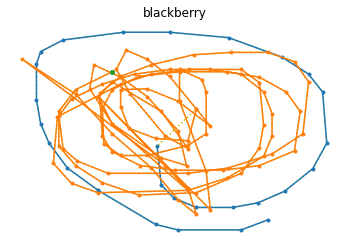

In [13]:
for sketches, lengths, labels in train_set.take(1):
  # a batch contains 32 sketches 
    print("sketches =", sketches.shape) # 32 sketches each with a variable length of 'strokes'
    print("lengths =", lengths.shape)
    print("labels =", labels.shape) 
    draw_sketch(sketches[2], label=labels[2])

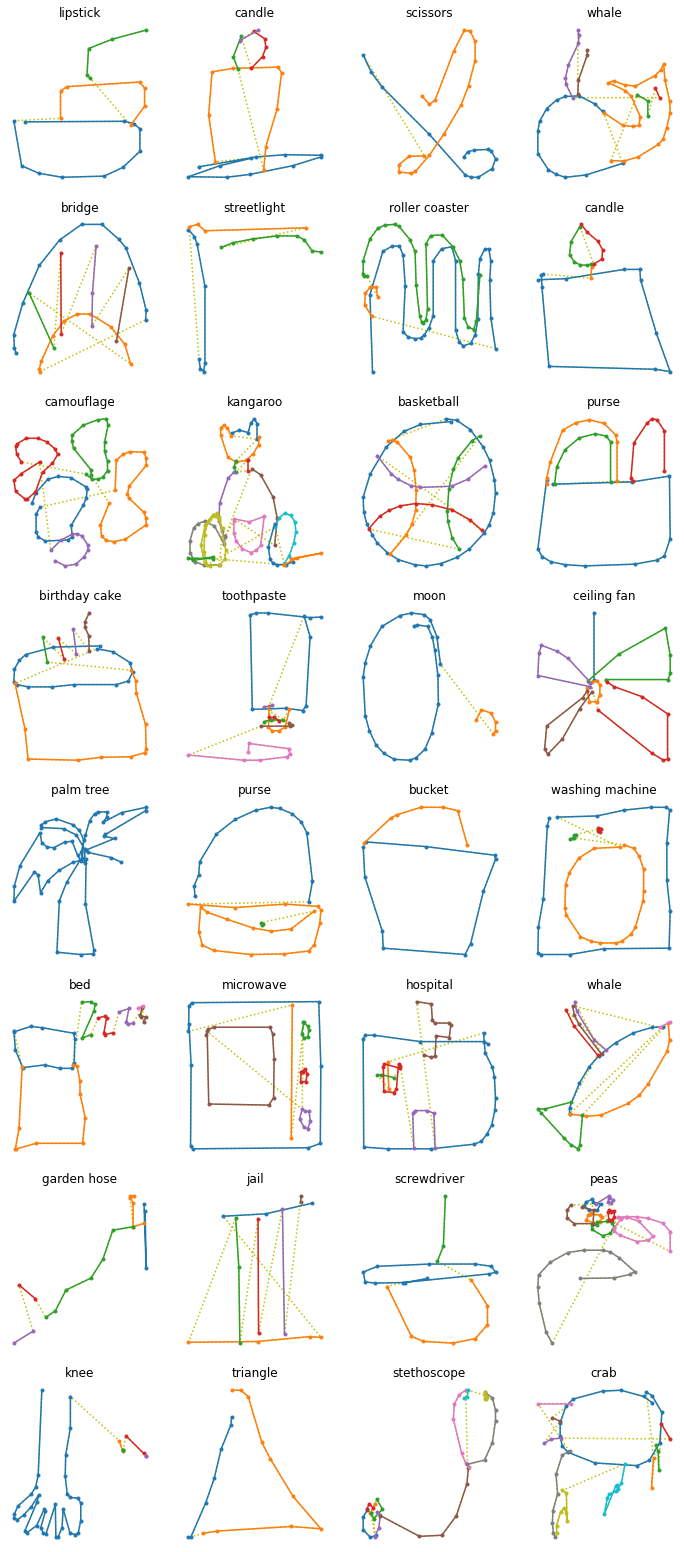

In [14]:
def draw_sketches(sketches, labels, lengths=None):
  """
  Use draw_sketch function and plot multiple skteches in one plot.
  """
  n_sketches = len(sketches)
  n_cols = 4
  n_rows = (n_sketches - 1) // n_cols + 1
  plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
  if lengths is not None:
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
      plt.subplot(n_rows, n_cols, index + 1)
      draw_sketch(sketch[:length], label)
  else:
    for index, sketch, label in zip(range(n_sketches), sketches, labels):
      plt.subplot(n_rows, n_cols, index + 1)
      draw_sketch(sketch, label)

  plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches=sketches, lengths=lengths, labels=labels)

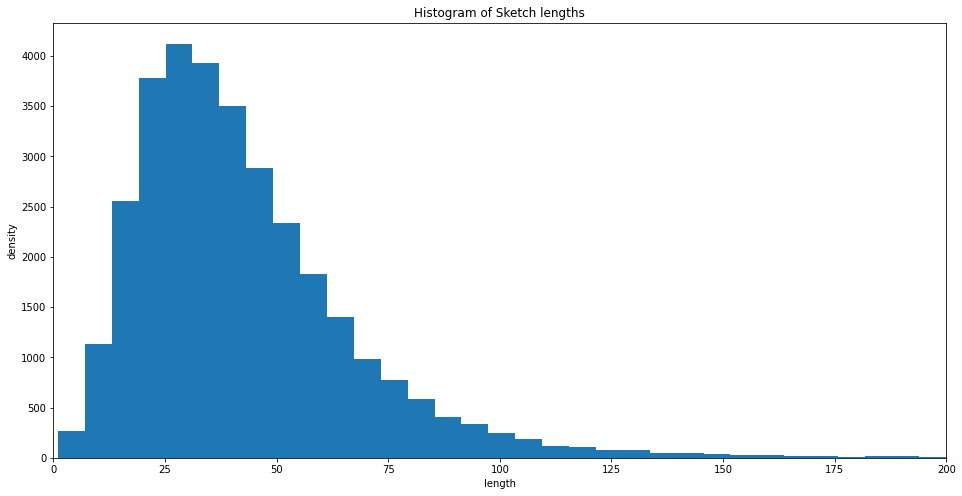

In [15]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.figure(figsize=(16,8))
plt.hist(lengths, bins=150)
plt.title('Histogram of Sketch lengths')
plt.xlabel("length")
plt.ylabel("density")
plt.xlim(0, 200)
plt.show()

In [16]:
def crop_long_sketches(dataset, max_length=100):
  """
  Remove sketches above max_length
  """
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

We now have a filtered dataset which consists of images that do not have a length more than 100. 

We can consider this as a short sequence, where each stroke has occured one after the other in order to form the sketch. 

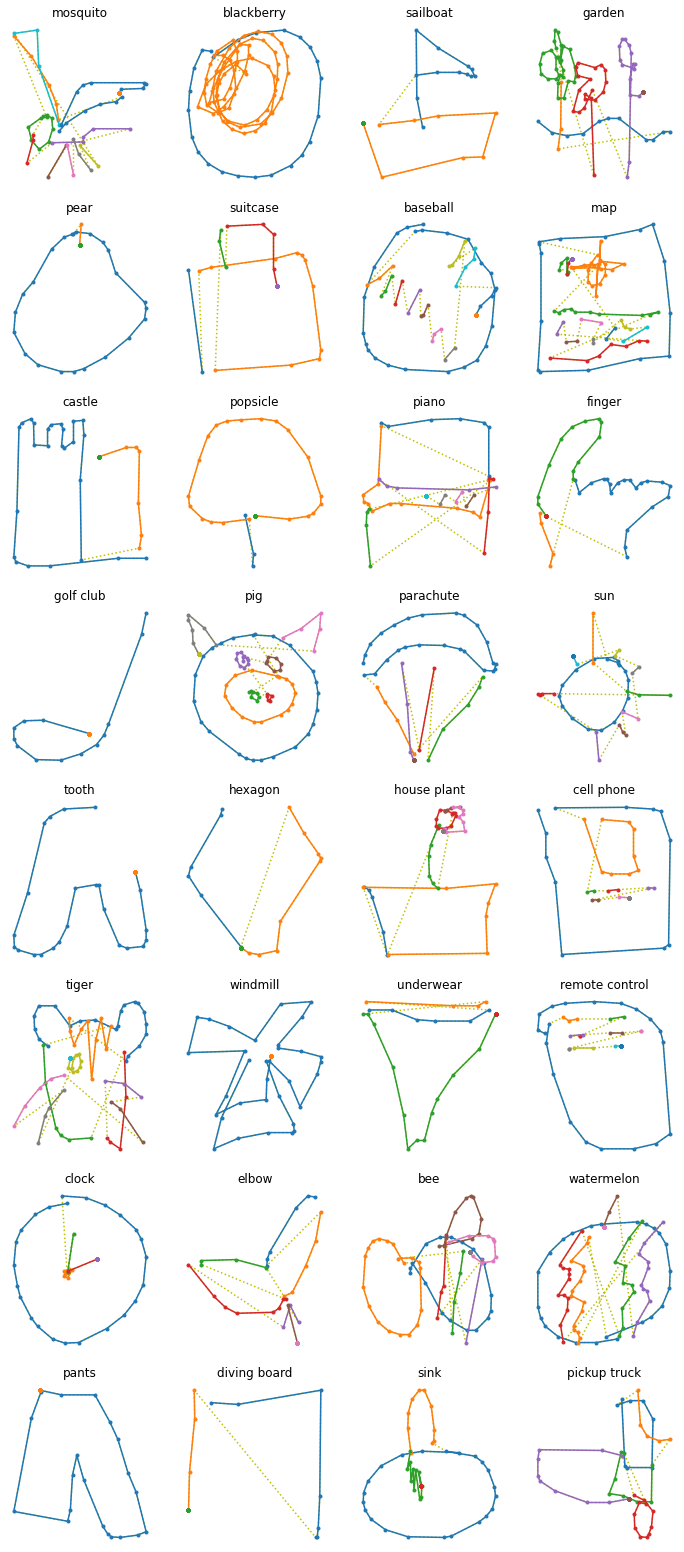

In [17]:
for sketches, labels in cropped_train_set.take(1):
    draw_sketches(sketches=sketches, labels=labels)

# Model

To build our model we first need to 'flatten' it so that the LSTM cells can take the model in and find patterns within the short sequence.

This model will be a Sequence to Vector model. 

In [18]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.RNN(keras.layers.LSTMCell(32), return_sequences=True),
  keras.layers.RNN(keras.layers.LSTMCell(32)),
  keras.layers.Dense(len(class_names), activation='softmax')
])

optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 4078s 38ms/step - loss: 4.9859 - accuracy: 0.0538 - sparse_top_k_categorical_accuracy: 0.1673 - val_loss: 4.1680 - val_accuracy: 0.1374 - val_sparse_top_k_categorical_accuracy: 0.3611
Epoch 2/2
107813/107813 [==============================] - 4168s 39ms/step - loss: 3.7092 - accuracy: 0.2089 - sparse_top_k_categorical_accuracy: 0.4671 - val_loss: 3.3689 - val_accuracy: 0.2594 - val_sparse_top_k_categorical_accuracy: 0.5379


This initial model was not great, lets try increase the number of Conv1D layers with Batch Normalization between.

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="tanh"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=5, strides=2, activation="tanh"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=3, strides=2, activation="tanh"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

model.fit(cropped_train_set, epochs=5, validation_data=cropped_valid_set)

Epoch 1/5
107813/107813 [==============================] - 6539s 61ms/step - loss: 2.5695 - accuracy: 0.4084 - sparse_top_k_categorical_accuracy: 0.6816 - val_loss: 1.8635 - val_accuracy: 0.5441 - val_sparse_top_k_categorical_accuracy: 0.8140
Epoch 2/5
107813/107813 [==============================] - 6778s 63ms/step - loss: 1.7149 - accuracy: 0.5765 - sparse_top_k_categorical_accuracy: 0.8351 - val_loss: 1.6462 - val_accuracy: 0.5916 - val_sparse_top_k_categorical_accuracy: 0.8461
Epoch 3/5
107813/107813 [==============================] - 7025s 65ms/step - loss: 1.5494 - accuracy: 0.6133 - sparse_top_k_categorical_accuracy: 0.8589 - val_loss: 1.5269 - val_accuracy: 0.6189 - val_sparse_top_k_categorical_accuracy: 0.8628
Epoch 4/5
107813/107813 [==============================] - 7064s 66ms/step - loss: 1.4721 - accuracy: 0.6307 - sparse_top_k_categorical_accuracy: 0.8694 - val_loss: 1.4945 - val_accuracy: 0.6271 - val_sparse_top_k_categorical_accuracy: 0.8677
Epoch 5/5
107813/107813 [===

This model is a lot better but the training did take a very long time - 108 mins per epoch! Nonethless, it is safe to say that having more filters and using a non-saturating activation function has helped the performance. I tried incorporate the WaveNet architecture but it started becoming more complex and gave up. :)

Feel free to DM me if you have one in mind, I found this on Kaggle: https://www.kaggle.com/kmader/quickdraw-with-wavenet-classifier


# Prediction on Test set

In [20]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [21]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.868033

# Plot Model Prediction on Sample Data

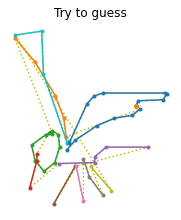

Top-5 predictions:
  1. broom 23.273%
  2. rake 16.491%
  3. mosquito 7.506%
  4. snowflake 6.339%
  5. helicopter 4.498%
Answer: mosquito


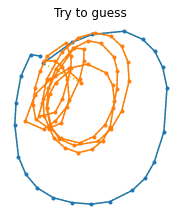

Top-5 predictions:
  1. blackberry 46.424%
  2. hurricane 10.813%
  3. onion 6.667%
  4. garden hose 6.596%
  5. blueberry 3.993%
Answer: blackberry


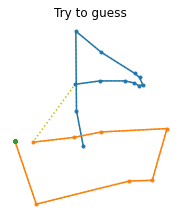

Top-5 predictions:
  1. lipstick 59.126%
  2. church 7.762%
  3. shovel 7.253%
  4. screwdriver 4.702%
  5. candle 4.486%
Answer: sailboat


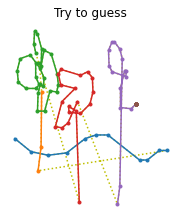

Top-5 predictions:
  1. garden 96.696%
  2. beach 3.199%
  3. camouflage 0.011%
  4. broccoli 0.011%
  5. tree 0.011%
Answer: garden


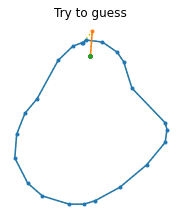

Top-5 predictions:
  1. potato 33.928%
  2. pear 24.498%
  3. clock 7.224%
  4. apple 6.790%
  5. blueberry 3.646%
Answer: pear


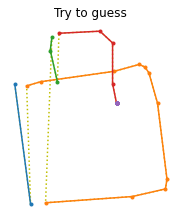

Top-5 predictions:
  1. suitcase 86.420%
  2. hospital 3.518%
  3. lipstick 1.801%
  4. church 1.735%
  5. toaster 1.295%
Answer: suitcase


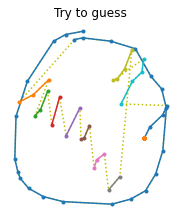

Top-5 predictions:
  1. pond 33.338%
  2. pool 28.905%
  3. brain 12.891%
  4. hedgehog 5.225%
  5. potato 3.712%
Answer: baseball


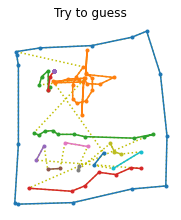

Top-5 predictions:
  1. passport 80.279%
  2. postcard 7.392%
  3. calendar 4.813%
  4. map 1.535%
  5. hospital 0.804%
Answer: map


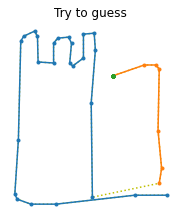

Top-5 predictions:
  1. castle 99.479%
  2. the great wall of china 0.372%
  3. fence 0.050%
  4. skyscraper 0.013%
  5. crown 0.012%
Answer: castle


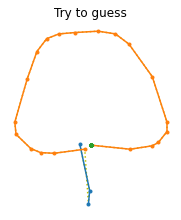

Top-5 predictions:
  1. popsicle 80.220%
  2. lollipop 11.314%
  3. mushroom 4.182%
  4. light bulb 1.592%
  5. umbrella 1.430%
Answer: popsicle


In [22]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(sketches[index])
  plt.show()
  print("Top-5 predictions:".format(index + 1))
  for k in range(5):
    class_name = class_names[top_k.indices[index, k]]
    proba = 100 * top_k.values[index, k]
    print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
  print("Answer: {}".format(class_names[labels[index].numpy()]))